In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import curve_fit

In [4]:
# --- Load data ---
edges_cols = ["source", "target", "time", "rating", "anal", "oral", "kiss"]
edges = pd.read_csv("edges.csv", comment="#", header=None, names=edges_cols)

nodes_cols = ["index", "male", "_pos"]
nodes = pd.read_csv("nodes.csv", comment="#", header=None, names=nodes_cols)

In [6]:
# --- Build aggregated undirected edge list (unique unordered pairs) ---
pairs = pd.DataFrame({
    "u": edges[["source", "target"]].min(axis=1),
    "v": edges[["source", "target"]].max(axis=1)
}).drop_duplicates()

# --- Build aggregated undirected graph G (as requested style) ---
G = nx.Graph()
G.add_edges_from(pairs.itertuples(index=False, name=None))

# --- Degree per node ---
deg_u = pairs["u"].value_counts()
deg_v = pairs["v"].value_counts()
deg = deg_u.add(deg_v, fill_value=0).astype(int)

# Add isolated nodes from nodes.csv (degree 0)
all_nodes = pd.Index(nodes["index"].unique())
deg = deg.reindex(all_nodes, fill_value=0)

# --- Stats ---
avg_degree = deg.mean()                  # average degree
std_degree_pop = deg.std(ddof=0)         # population std deviation
std_degree_sample = deg.std(ddof=1)      # sample std (optional)

num_edges = len(pairs)
num_nodes = len(all_nodes)

print(f"Nodes (V): {num_nodes}")
print(f"Edges (E): {num_edges}")
print(f"Average degree: {avg_degree:.6f}")
print(f"Std. dev. (population, ddof=0): {std_degree_pop:.6f}")

Nodes (V): 16730
Edges (E): 39044
Average degree: 4.667543
Std. dev. (population, ddof=0): 10.449437


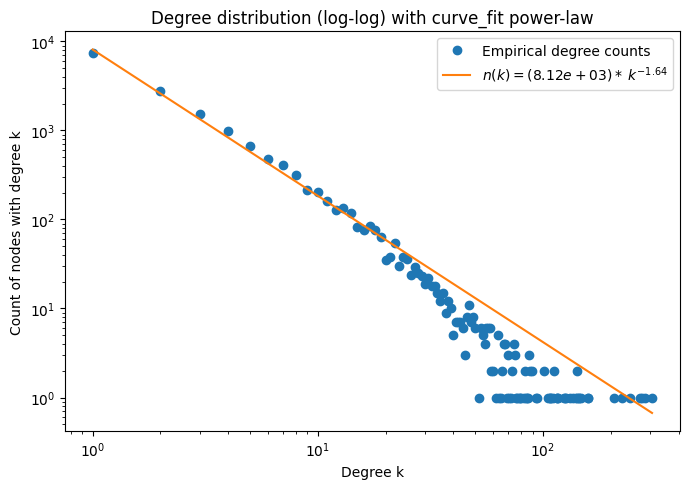

=== curve_fit Power-law Parameters ===
alpha: 1.643605
C: 8.121774e+03
Straight line on log-log plot --> scale free network


In [7]:
all_nodes = pd.Index(nodes["index"].unique())
deg = deg.reindex(all_nodes, fill_value=0).astype(int)
degrees = deg.values

# --- Degree histogram (exact degree bins) ---
deg_counts = pd.Series(degrees).value_counts().sort_index()
k = deg_counts.index.values.astype(float)
n = deg_counts.values.astype(float)

# Remove bins with zero height (explicitly)
mask = n > 0
k = k[mask]
n = n[mask]

# --- Take logs ---
x = np.log(k)
y = np.log(n)

# --- Fit log n = a + b log k with curve_fit ---
def linear_in_log(x, a, b):
    return a + b * x

# Initial guess and optional weights (downweight noisy tail)
p0 = (np.mean(y), -2.0)
sigma = 1.0 / np.sqrt(n)  # optional; remove if you want unweighted

params, cov = curve_fit(linear_in_log, x, y, p0=p0, sigma=sigma, absolute_sigma=False, maxfev=10000)
a_hat, b_hat = params
alpha_hat = -b_hat
C_hat = np.exp(a_hat)

# Predicted counts at observed k (in original space)
n_fit = C_hat * k**(-alpha_hat)

# --- Plot ---
plt.figure(figsize=(7,5))
plt.loglog(k, n, marker='o', linestyle='None', label='Empirical degree counts')
plt.loglog(k, n_fit, linestyle='-', label=rf"$n(k) = ({C_hat:.2e})*\;k^{{-{alpha_hat:.2f}}}$")
plt.xlabel("Degree k")
plt.ylabel("Count of nodes with degree k")
plt.title("Degree distribution (log-log) with curve_fit power-law")
plt.legend()
plt.tight_layout()
plt.show()

print("=== curve_fit Power-law Parameters ===")
print(f"alpha: {alpha_hat:.6f}")
print(f"C: {C_hat:.6e}")
print(f"Straight line on log-log plot --> scale free network")

In [8]:
print("Degree correlation (assortativity) ρD:", nx.degree_assortativity_coefficient(G))

Degree correlation (assortativity) ρD: -0.10973635444115819


In [9]:
C = nx.average_clustering(G)
print(f"Average clustering coefficient C: {C:.6f}, makes sense, since male-male edges and female-female edges don't exist")

Average clustering coefficient C: 0.000000, makes sense, since male-male edges and female-female edges don't exist


In [10]:
random.seed(0)

def avg_hopcount_sampled(G, k=9000):
    nodes = list(G.nodes())
    sources = random.sample(nodes, min(k, len(nodes)))
    total = 0
    cnt = 0
    diam = 0
    for u in sources:
        distmap = nx.single_source_shortest_path_length(G, u)
        if distmap:
            diam = max(diam, max(distmap.values(), default=0))
        for v, d in distmap.items():
            if u < v:
                total += d
                cnt += 1
    return total / cnt, diam

E_H_est, Hmax_lowerbound = avg_hopcount_sampled(G, k=300)
print(f"Estimated average hopcount (300 sources): {E_H_est:.4f}")
print(f"Diameter lower bound from sample: {Hmax_lowerbound}")


Estimated average hopcount (300 sources): 5.7595
Diameter lower bound from sample: 16


In [ ]:
print("hello world")

Small world property? 

Conditions:
1) short paths (satisfied)
2) high clustering (not satisfied)

Conclusion: no